In [1]:
#import libraries
import numpy as np
import pandas as pd
import datetime
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Importing Data

In [2]:
steam_data = pd.read_csv('AllSteamData.csv')
steam_data.head()

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
0,Counter-Strike,Last 30 Days,8488.74,27.6,0.33%,15065
1,Counter-Strike,Sep-21,8461.12,-390.07,-4.41%,14559
2,Counter-Strike,Aug-21,8851.19,-286.57,-3.14%,14064
3,Counter-Strike,Jul-21,9137.76,-359.69,-3.79%,14972
4,Counter-Strike,Jun-21,9497.45,-1243.5,-11.58%,16391


In [3]:
steam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878175 entries, 0 to 878174
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Name          878175 non-null  object 
 1   Month         878175 non-null  object 
 2   Avg. Players  878175 non-null  float64
 3   Gain          867341 non-null  object 
 4   % Gain        867341 non-null  object 
 5   Peak Players  878175 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 40.2+ MB


# Cleaning Dataset

In [4]:
steam_data_clean=steam_data.copy()
steam_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878175 entries, 0 to 878174
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Name          878175 non-null  object 
 1   Month         878175 non-null  object 
 2   Avg. Players  878175 non-null  float64
 3   Gain          867341 non-null  object 
 4   % Gain        867341 non-null  object 
 5   Peak Players  878175 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 40.2+ MB


In [5]:
#Drop Duplicates
steam_data_clean.drop_duplicates()

#cleaning the % Gain column
steam_data_clean['% Gain'] = steam_data_clean['% Gain'].str.replace("%","")

#filling the NULL values in Gain and % Gain to 0
steam_data_clean.Gain[steam_data_clean.Gain == '-'] = 0
steam_data_clean['% Gain'][steam_data_clean['% Gain'] == 'NaN'] = 0
steam_data_clean['% Gain'][steam_data_clean['% Gain'] == '-'] = 0
steam_data_clean.fillna(value = 0, inplace = True)

#cleaning the Month column
steam_data_clean['Month'] = steam_data_clean['Month'].str.replace("Last 30 Days","Oct-21")
steam_data_clean['Month'] = pd.to_datetime(steam_data_clean['Month'], format='%b-%y')

steam_data_clean

C:\Users\choww\AppData\Local\Temp/ipykernel_6432/1104227979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_data_clean.Gain[steam_data_clean.Gain == '-'] = 0
C:\Users\choww\AppData\Local\Temp/ipykernel_6432/1104227979.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_data_clean['% Gain'][steam_data_clean['% Gain'] == 'NaN'] = 0
C:\Users\choww\AppData\Local\Temp/ipykernel_6432/1104227979.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
0,Counter-Strike,2021-10-01,8488.74,27.6,0.33,15065
1,Counter-Strike,2021-09-01,8461.12,-390.07,-4.41,14559
2,Counter-Strike,2021-08-01,8851.19,-286.57,-3.14,14064
3,Counter-Strike,2021-07-01,9137.76,-359.69,-3.79,14972
4,Counter-Strike,2021-06-01,9497.45,-1243.5,-11.58,16391
...,...,...,...,...,...,...
878170,Ultra Age Demo,2021-10-01,5.45,0,0,35
878171,Grim Tales: Crimson Hollow Collector's Edition,2021-10-01,2.40,0,0,9
878172,Everyday Life in Hospital VR,2021-10-01,0.00,0,0,0
878173,Martha Is Dead Demo,2021-10-01,9.03,0,0,41


In [6]:
steam_data_clean.sample(20)

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
39633,Manhunt,2018-01-01,4.53,1.36,42.94,71
137068,Memoir '44 Online,2015-02-01,7.16,-1.36,-15.99,26
617169,Q.U.I.R.K.,2018-08-01,4.74,-0.38,-7.34,11
69229,East India Company,2020-02-01,3.42,0.64,23.18,11
496539,Transport Fever,2020-03-01,728.81,22.46,3.18,1514
582370,SYMMETRY,2019-06-01,0.20,-0.14,-41.48,2
370838,The Black Watchmen,2016-11-01,6.65,-3.73,-35.93,26
25700,Sid Meier's Railroads!,2013-11-01,34.13,-2.01,-5.57,80
279937,Whispering Willows,2014-08-01,6.68,1.96,41.42,27
316748,Duck Game,2019-08-01,255.71,-82.88,-24.48,432


In [7]:
steam_data_clean.describe()

,Avg. Players,Peak Players
count,8.781750e+05,8.781750e+05
mean,3.298315e+02,6.828038e+02
std,8.601823e+03,1.623968e+04
min,0.000000e+00,0.000000e+00
25%,3.900000e-01,3.000000e+00
50%,2.520000e+00,1.100000e+01
75%,1.752000e+01,5.700000e+01
max,1.584887e+06,3.236027e+06


# Exploring the Dataset

In [8]:
#Top 10 Games by Avg Players for all time
Top_10_alltime = steam_data_clean.sort_values('Avg. Players', ascending=False)

#Only keep the Highest occurence
Top_10_alltime = Top_10_alltime.drop_duplicates(subset=['Name'], keep='first').head(10)
Top_10_alltime

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
618079,PUBG: BATTLEGROUNDS,2018-01-01,1584886.77,148728.26,10.36,3236027
3364,Counter-Strike: Global Offensive,2020-04-01,857604.22,186570.94,27.80,1305714
3078,Dota 2,2016-02-01,709178.26,97003.48,15.85,1248394
817899,New World,2021-10-01,461109.04,0,0,913027
824204,Cyberpunk 2077,2020-12-01,332395.65,0,0,830387
413277,Fallout 4,2015-11-01,226297.83,0,0,471955
771929,Valheim,2021-02-01,210302.24,0,0,498478
258827,Grand Theft Auto V,2015-04-01,192714.01,0,0,360761
621248,Monster Hunter: World,2018-08-01,188291.24,0,0,329333
787669,Among Us,2020-10-01,176453.91,25073.63,16.56,372646


<AxesSubplot:xlabel='Avg. Players', ylabel='Name'>

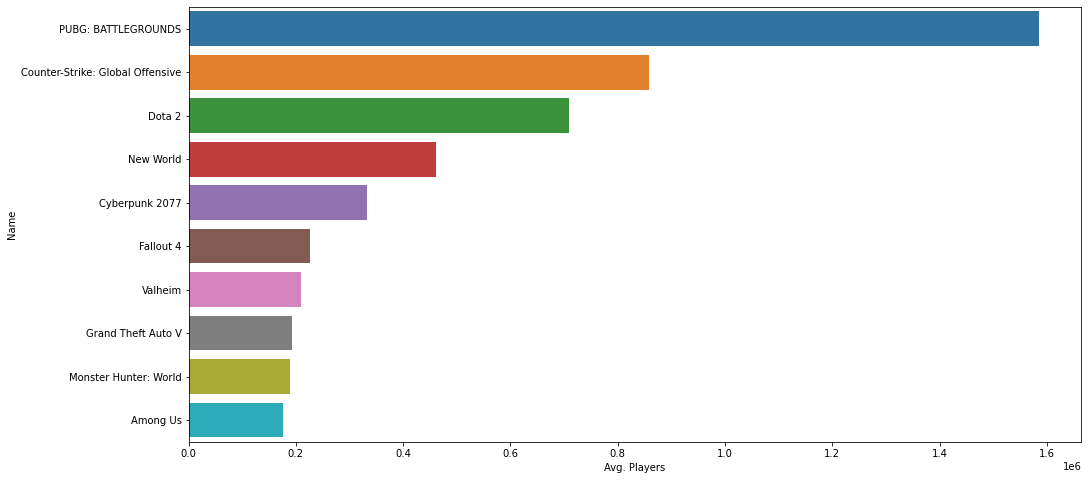

In [9]:
#Exploring data range for Avg. Players
avg = pd.DataFrame(Top_10_alltime[["Avg. Players", "Name"]])

#Using Bar graph
f = plt.figure(figsize=(16, 8))
sb.barplot(x="Avg. Players", y="Name", data=avg)

It can be seen that there is a huge disparity between the number of average players for the top 10 games of all time. With PUBG having the most obvious lead followed by Counter-Strike and Dota 2 having a significant lead from the 4th palce as well.

In [10]:
# Top 10 from the most recent month Oct 2021
Top_10_recent = steam_data_clean.loc[steam_data_clean['Month'] == '2021-10-01']
Top_10_recent = Top_10_recent.sort_values('Avg. Players', ascending=False)

#Only keep the Highest occurence
Top_10_recent = Top_10_recent.drop_duplicates(subset=['Name'], keep='first').head(10)
Top_10_recent

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
3346,Counter-Strike: Global Offensive,2021-10-01,518660.99,6310.1,1.23,942519
817899,New World,2021-10-01,461109.04,0,0,913027
3010,Dota 2,2021-10-01,418920.68,27838.6,7.12,740925
618034,PUBG: BATTLEGROUNDS,2021-10-01,161305.35,-5796.8,-3.47,393496
839174,Apex Legends,2021-10-01,126880.65,-12767.3,-9.14,246412
2456,Team Fortress 2,2021-10-01,84650.40,2796.4,3.42,106533
822922,Destiny 2,2021-10-01,72057.26,-17787.9,-19.80,127770
258749,Grand Theft Auto V,2021-10-01,71583.79,-9648.4,-11.88,132146
228808,Rust,2021-10-01,62871.27,-6631.7,-9.54,106571
843804,NARAKA: BLADEPOINT,2021-10-01,57486.19,-6786,-10.56,160720


<AxesSubplot:xlabel='Avg. Players', ylabel='Name'>

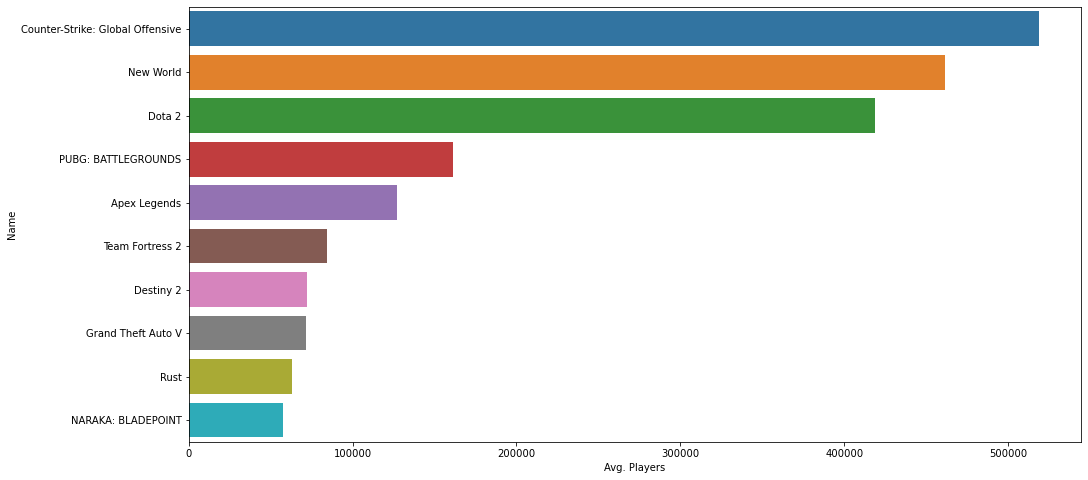

In [11]:
#Exploring data range for Avg. Players
avg_recent = pd.DataFrame(Top_10_recent[["Avg. Players", "Name"]])

#Using Bar graph
f = plt.figure(figsize=(16, 8))
sb.barplot(x="Avg. Players", y="Name", data=avg_recent)

From the most recent month, we can again see that there seems to be a huge disparity between games. However, this disparity has shrunk and the top average players also has dipped. The top three games have a clear lead from the rest of the games and there also also some familiar faces from the top 10 games of all time.

In [12]:
# Top 10 from the most dated month July 2012
Top_10_dated = steam_data_clean.loc[steam_data_clean['Month'] == '2012-07-01']
Top_10_dated = Top_10_dated.sort_values('Avg. Players', ascending=False)

#Only keep the Highest occurence
Top_10_dated = Top_10_dated.drop_duplicates(subset=['Name'], keep='first').head(10)
Top_10_dated

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
3121,Dota 2,2012-07-01,52721.05,0,0,75041
2567,Team Fortress 2,2012-07-01,45566.90,0,0,62321
111,Counter-Strike,2012-07-01,34139.20,0,0,53967
124607,Football Manager 2012,2012-07-01,30730.75,0,0,60437
1448,Counter-Strike: Source,2012-07-01,27969.52,0,0,47909
30727,Sid Meier's Civilization V,2012-07-01,27448.46,0,0,50756
125931,The Elder Scrolls V: Skyrim,2012-07-01,24254.09,0,0,39658
101476,Call of Duty: Modern Warfare 3 - Multiplayer,2012-07-01,18726.93,0,0,36521
3009,Left 4 Dead 2,2012-07-01,12228.47,0,0,21811
135618,Terraria,2012-07-01,9022.77,0,0,16097


<AxesSubplot:xlabel='Avg. Players', ylabel='Name'>

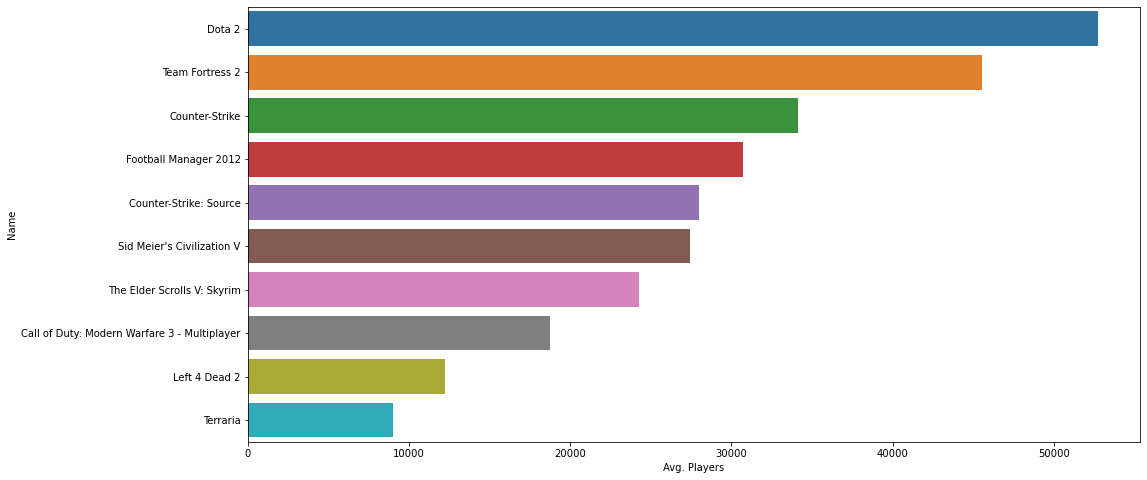

In [13]:
#Exploring data range for Avg. Players
avg_dated = pd.DataFrame(Top_10_dated[["Avg. Players", "Name"]])

#Using Bar graph
f = plt.figure(figsize=(16, 8))
sb.barplot(x="Avg. Players", y="Name", data=avg_dated)

Games in the past seem to have a more even distribution of average players comapared to the recent month and we can see that some popular games in the recent month has the popularity even in the dated month.

In [14]:
# Top 10 from the month between recent and dated March 2017
Top_10_middle = steam_data_clean.loc[steam_data_clean['Month'] == '2017-03-01']
Top_10_middle = Top_10_middle.sort_values('Avg. Players', ascending=False)

#Only keep the Highest occurence
Top_10_middle = Top_10_middle.drop_duplicates(subset=['Name'], keep='first').head(10)
Top_10_middle

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
3065,Dota 2,2017-03-01,548435.44,-43131.81,-7.29,956232
3401,Counter-Strike: Global Offensive,2017-03-01,386908.72,-15476.99,-3.85,742356
482364,Z1 Battle Royale,2017-03-01,62621.01,20656.87,49.23,123838
2511,Team Fortress 2,2017-03-01,49483.19,-2304.17,-4.45,74656
258804,Grand Theft Auto V,2017-03-01,48616.89,-4654.1,-8.74,98798
366122,ARK: Survival Evolved,2017-03-01,41052.97,-12081.74,-22.74,75022
529180,Football Manager 2017,2017-03-01,34001.59,-1073.52,-3.06,62590
229542,Rocket League,2017-03-01,33763.69,498.45,1.50,74330
228863,Rust,2017-03-01,32438.98,-3964.56,-10.89,66194
192381,Warframe,2017-03-01,30723.66,2325.41,8.19,69526


<AxesSubplot:xlabel='Avg. Players', ylabel='Name'>

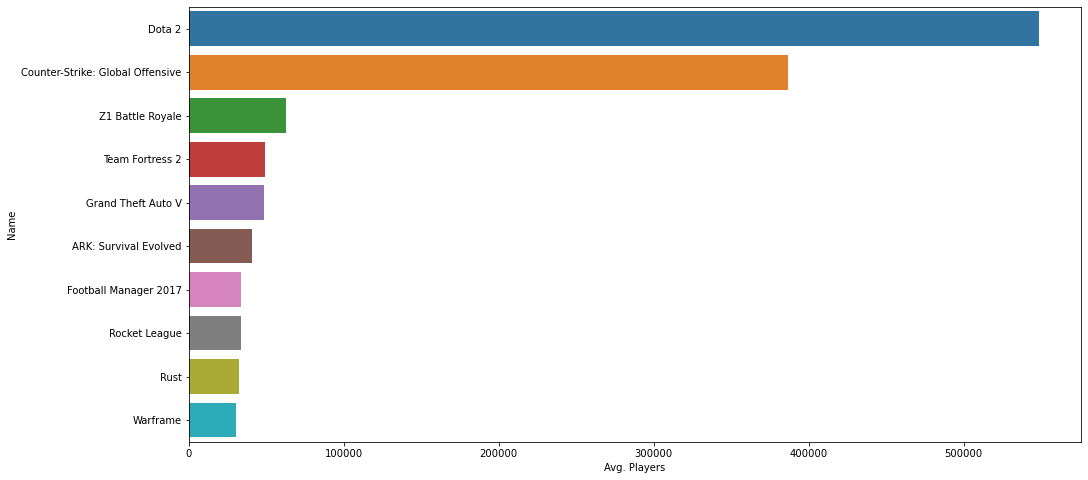

In [15]:
#Exploring data range for Avg. Players
avg_middle = pd.DataFrame(Top_10_middle[["Avg. Players", "Name"]])

#Using Bar graph
f = plt.figure(figsize=(16, 8))
sb.barplot(x="Avg. Players", y="Name", data=avg_middle)

By analysing the month in between the dated and the recent month, we hope to observe any trends that can be seen throughout, and once again, the average players are dominated by the top games of the month.

<AxesSubplot:xlabel='Avg. Players', ylabel='Name'>

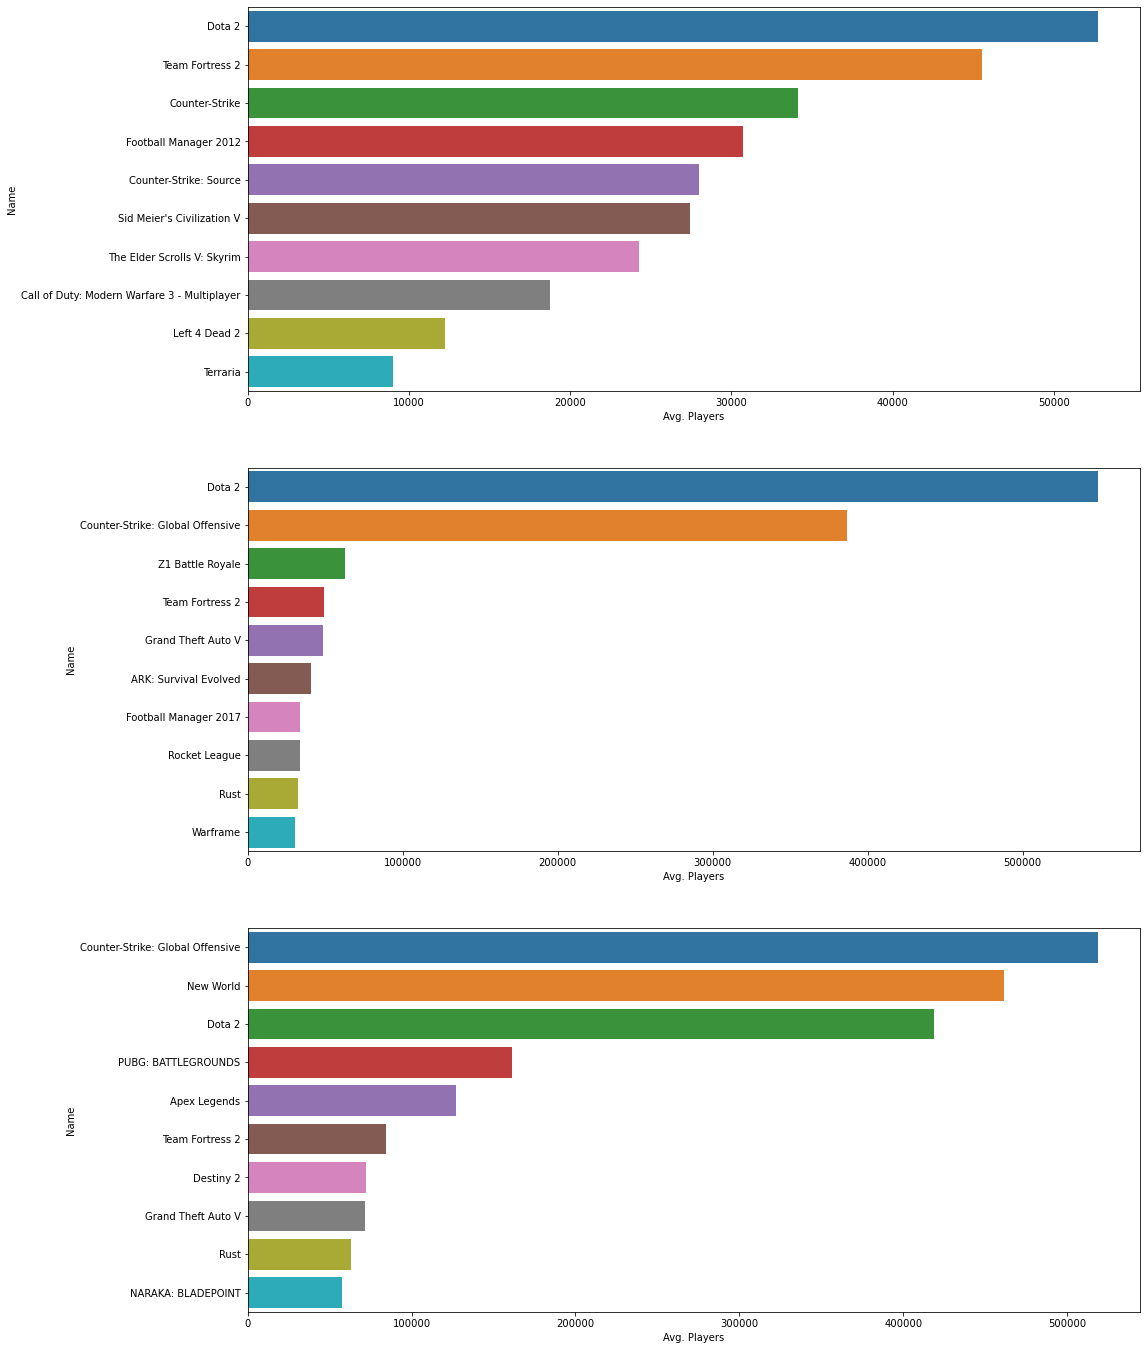

In [16]:
f, axes = plt.subplots(3,1, figsize=(16, 24))

sb.barplot(x="Avg. Players", y="Name", data=avg_dated, orient = "h", ax = axes[0])
sb.barplot(x="Avg. Players", y="Name", data=avg_middle, orient = "h", ax = axes[1])
sb.barplot(x="Avg. Players", y="Name", data=avg_recent, orient = "h", ax = axes[2])

By ordering the graph from the most dated to the most recent, we observe that games such as Dota 2 and Counter-Strike: Global Offensive and even Team Fortress 2 have maintained their player bases throughout a long period of time.

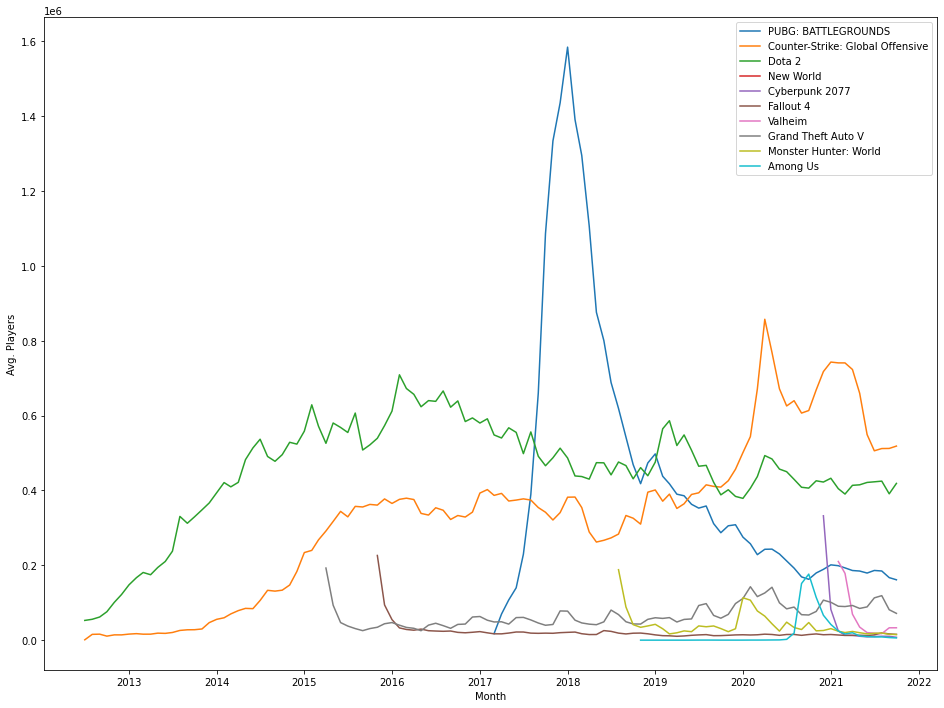

In [17]:
#Comparing the top 10 games of all time in a line plot
f = plt.figure(figsize=(16, 12))
for i in Top_10_alltime['Name']:
    line_data = steam_data_clean.loc[steam_data_clean['Name'] == i]
    sb.lineplot(x = 'Month', y = 'Avg. Players', data = line_data, legend='brief', label=str(i))

From this graph, we see that most of the games follow the same trend where they have a high average player count but rapidly loses those average players in less than 6 months. We can clearly see these trends for games such as Cyberpunk 2077 or Valheim.

However, exceptions such as Counter-Strike: Global Offensive and DOTA 2 are able to maintain a healthy player base throughout the months. Even more so, the average players of these two games far outweigh the average players from the other games, even at their peak.

One more exception would be PUBG. PUBG saw an explosive growth in 2018 where it experienced twice as much average players than DOTA 2 or Counter-Strike: Global Offensive. However, since that, the game has been seeing a decline in average players to the point that now it has half the players DOTA 2 and Counter-Strike: Global Offensive has.

It is also important to note that New World is not depicted in the line plot as it was a newly released game in the month of October 2021.

# Time Series Forecasting

## Dota 2

In [18]:
Dota = steam_data_clean.loc[steam_data_clean['Name'] == 'Dota 2']
Dota = Dota[['Avg. Players', 'Month']]
Dota = Dota.sort_values('Month', ascending=True)
Dota.set_index('Month', inplace=True)
Dota

,Avg. Players
Month,
2012-07-01,52721.05
2012-08-01,55768.61
2012-09-01,61867.68
2012-10-01,75965.44
2012-11-01,101077.43
...,...
2021-06-01,421509.96
2021-07-01,423156.18
2021-08-01,424980.17


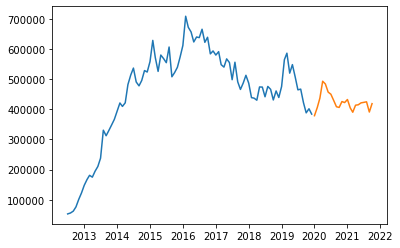

In [19]:
train = Dota[:90]
test = Dota[-22:]
plt.plot(train)
plt.plot(test)

In [20]:
model =  pm.auto_arima(train,start_p=0, d=None, start_q=0, 
                          max_p=50, max_d=50, max_q=50, start_P=0, 
                          D=1, start_Q=0, max_P=50, max_D=50,
                          max_Q=50, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1869.618, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1856.690, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1849.895, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1870.417, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1851.883, Time=0.05 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1851.883, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1857.190, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1853.716, Time=0.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1844.881, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1846.072, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1853.664, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1849.000, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]     

In [21]:
prediction = pd.DataFrame(model.predict(n_periods = 22), index=test.index)
prediction.columns = ['Predicted Players']
check = pd.DataFrame(model.predict_in_sample(), index=train.index)
prediction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2020-01-01 to 2021-10-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Predicted Players  22 non-null     float64
dtypes: float64(1)
memory usage: 352.0 bytes


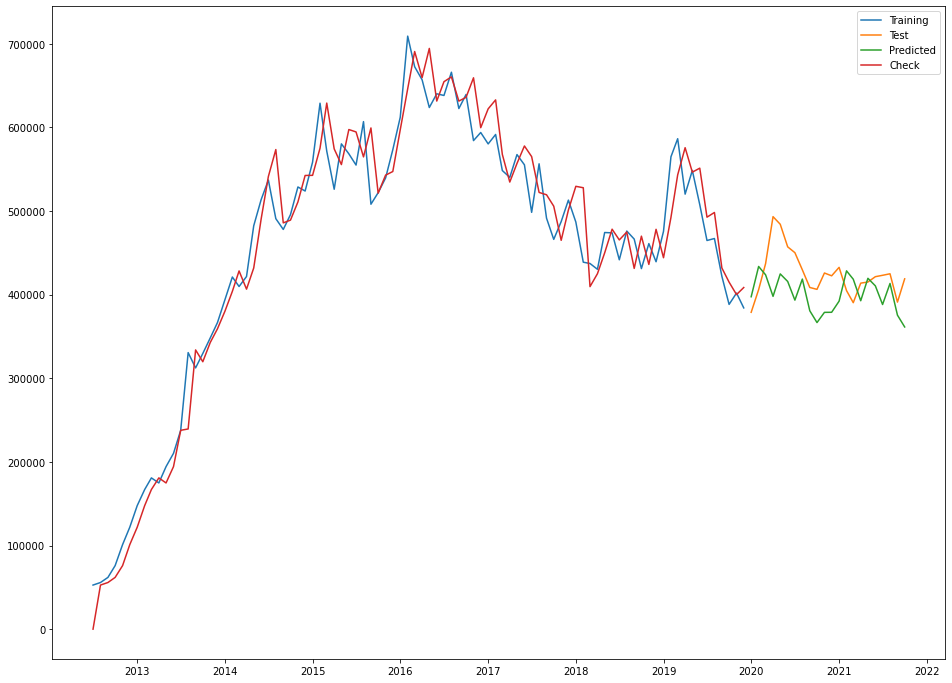

In [22]:
plt.figure(figsize = (16, 12))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.plot(check,label="Check")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import r2_score
r2_score(test['Avg. Players'], prediction['Predicted Players'])

-1.0932487868435583

## Counter-Strike: Global Offensive

In [24]:
CSGO = steam_data_clean.loc[steam_data_clean['Name'] == 'Counter-Strike: Global Offensive']
CSGO = CSGO[['Avg. Players', 'Month']]
CSGO = CSGO.sort_values('Month', ascending=True)
CSGO.set_index('Month', inplace=True)
CSGO

,Avg. Players
Month,
2012-07-01,932.57
2012-08-01,15475.39
2012-09-01,16000.75
2012-10-01,10739.48
2012-11-01,14134.10
...,...
2021-06-01,549347.08
2021-07-01,506067.36
2021-08-01,512081.96


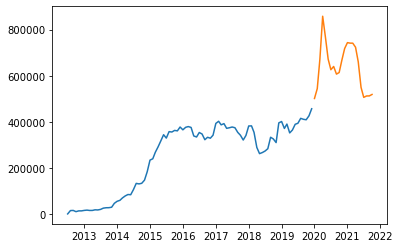

In [25]:
train = CSGO[:90]
test = CSGO[-22:]
plt.plot(train)
plt.plot(test)

In [26]:
model =  pm.auto_arima(train,start_p=0, d=None, start_q=0, 
                          max_p=50, max_d=50, max_q=50, start_P=0, 
                          D=1, start_Q=0, max_P=50, max_D=50,
                          max_Q=50, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1791.913, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1777.084, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1771.904, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1791.723, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1773.841, Time=0.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1773.833, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1777.737, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1775.820, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1763.297, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1771.492, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1774.041, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1770.952, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]     

In [27]:
prediction = pd.DataFrame(model.predict(n_periods = 22), index=test.index)
prediction.columns = ['Predicted Players']
check = pd.DataFrame(model.predict_in_sample(), index=train.index)
prediction

,Predicted Players
Month,
2020-01-01,476836.191990
2020-02-01,474603.231664
2020-03-01,475668.914896
2020-04-01,460657.730861
2020-05-01,454786.283127
2020-06-01,463128.197313
2020-07-01,468361.157289
2020-08-01,479450.865459
2020-09-01,480991.730090


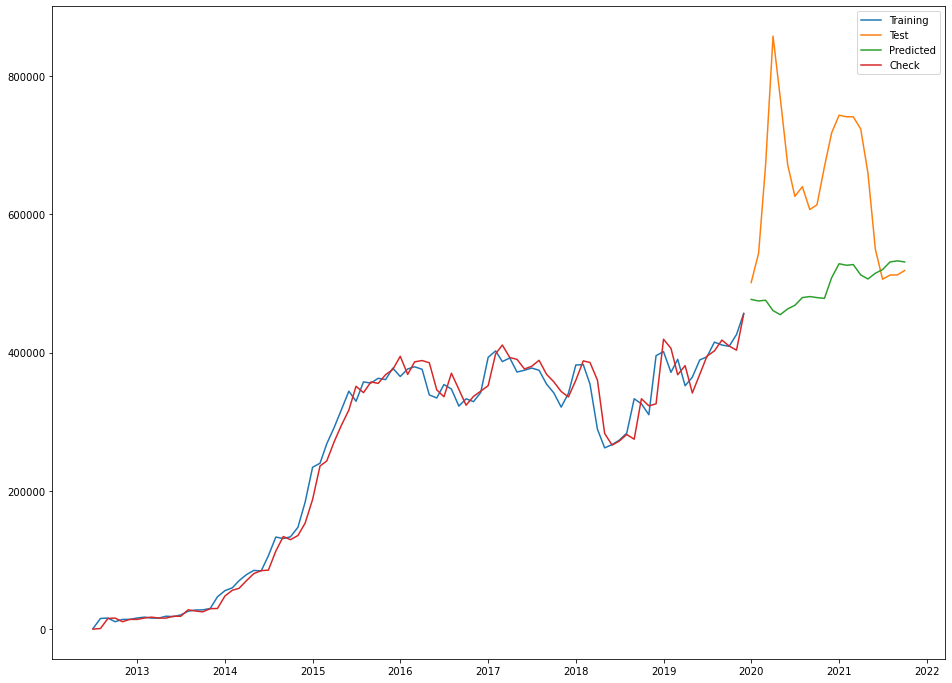

In [28]:
plt.figure(figsize = (16, 12))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.plot(check,label="Check")
plt.legend()
plt.show()

## PUBG: BATTLEGROUNDS

In [29]:
Pubg = steam_data_clean.loc[steam_data_clean['Name'] == 'PUBG: BATTLEGROUNDS']
Pubg = Pubg[['Avg. Players', 'Month']]
Pubg = Pubg.sort_values('Month', ascending=True)
Pubg.set_index('Month', inplace=True)
Pubg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2017-03-01 to 2021-10-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Avg. Players  56 non-null     float64
dtypes: float64(1)
memory usage: 896.0 bytes


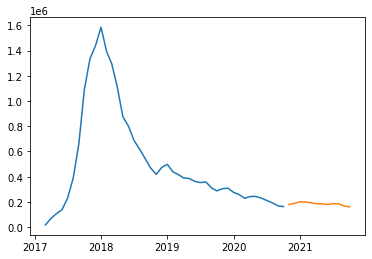

In [30]:
train = Pubg[:44]
test = Pubg[-12:]
plt.plot(train)
plt.plot(test)

In [31]:
model =  pm.auto_arima(train,start_p=0, d=None, start_q=0, 
                          max_p=50, max_d=50, max_q=50, start_P=0, 
                          D=1, start_Q=0, max_P=50, max_D=50,
                          max_Q=50, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=10,n_fits = 50 )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=940.306, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=838.424, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=902.912, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=943.262, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=852.872, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=837.934, Time=0.09 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=839.933, Time=0.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=838.845, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=840.309, Time=0.04 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=840.264, Time=0.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=932.541, Time=0.05 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=816.596, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=818.553, Time=0.04 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=818.215, Time=0.23 sec
 ARIMA(2,0,0)(2,1,1)[12] intercep

In [32]:
prediction = pd.DataFrame(model.predict(n_periods = 12), index=test.index)
prediction.columns = ['Predicted Players']
check = pd.DataFrame(model.predict_in_sample(), index=train.index)
prediction

,Predicted Players
Month,
2020-11-01,148490.404193
2020-12-01,119916.003703
2021-01-01,98318.885073
2021-02-01,53321.333301
2021-03-01,37155.208579
2021-04-01,51340.466293
2021-05-01,54816.294511
2021-06-01,69711.495343
2021-07-01,138401.242156


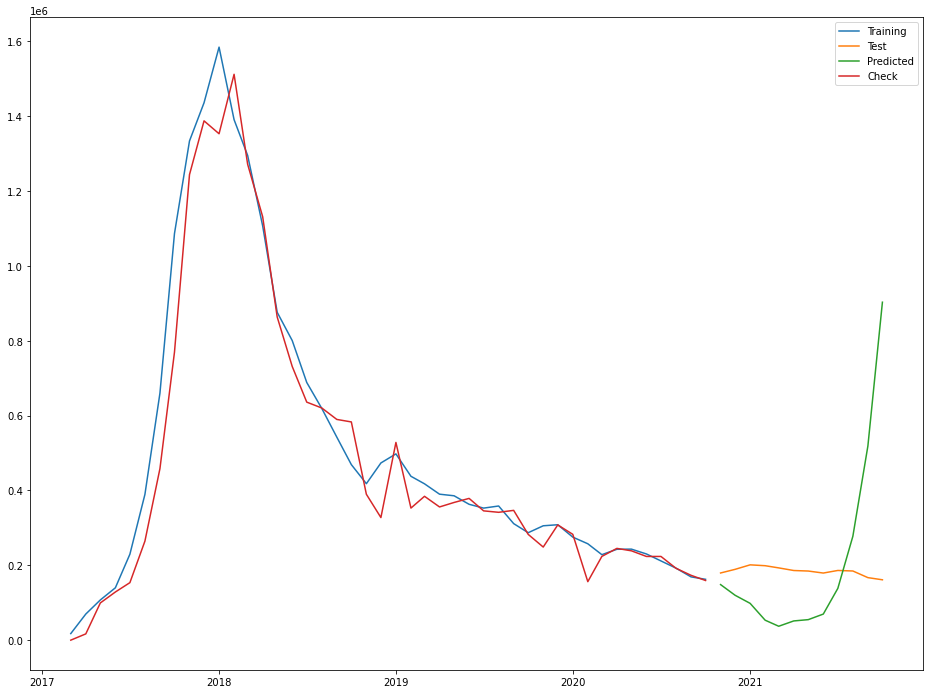

In [33]:
plt.figure(figsize = (16, 12))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.plot(check,label="Check")
plt.legend()
plt.show()

## Grand Theft Auto V

In [34]:
Gta = steam_data_clean.loc[steam_data_clean['Name'] == 'Grand Theft Auto V']
Gta = Gta[['Avg. Players', 'Month']]
Gta = Gta.sort_values('Month', ascending=True)
Gta.set_index('Month', inplace=True)
Gta

,Avg. Players
Month,
2015-04-01,192714.01
2015-05-01,93361.62
2015-06-01,46953.24
2015-07-01,37657.07
2015-08-01,30918.06
...,...
2021-06-01,88915.40
2021-07-01,112995.42
2021-08-01,118900.57


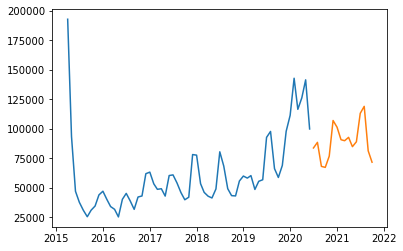

In [35]:
train = Gta[:63]
test = Gta[-16:]
plt.plot(train)
plt.plot(test)

In [51]:
model =  pm.auto_arima(train,start_p=0, d=None, start_q=0, 
                          max_p=50, max_d=50, max_q=50, start_P=0, 
                          D=1, start_Q=0, max_P=50, max_D=50,
                          max_Q=50, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=10,n_fits = 50 )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1138.541, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1133.270, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1124.192, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1126.324, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1126.050, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1124.340, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1132.091, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1106.646, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1105.304, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1106.648, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1137.808, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]          

In [52]:
prediction = pd.DataFrame(model.predict(n_periods = 16), index=test.index)
prediction.columns = ['Predicted Players']
check = pd.DataFrame(model.predict_in_sample(), index=train.index)
prediction

,Predicted Players
Month,
2020-07-01,144634.611761
2020-08-01,160083.232879
2020-09-01,130249.159554
2020-10-01,124455.926229
2020-11-01,136325.082903
2020-12-01,166942.149578
2021-01-01,182146.966253
2021-02-01,215253.552928
2021-03-01,190597.749603


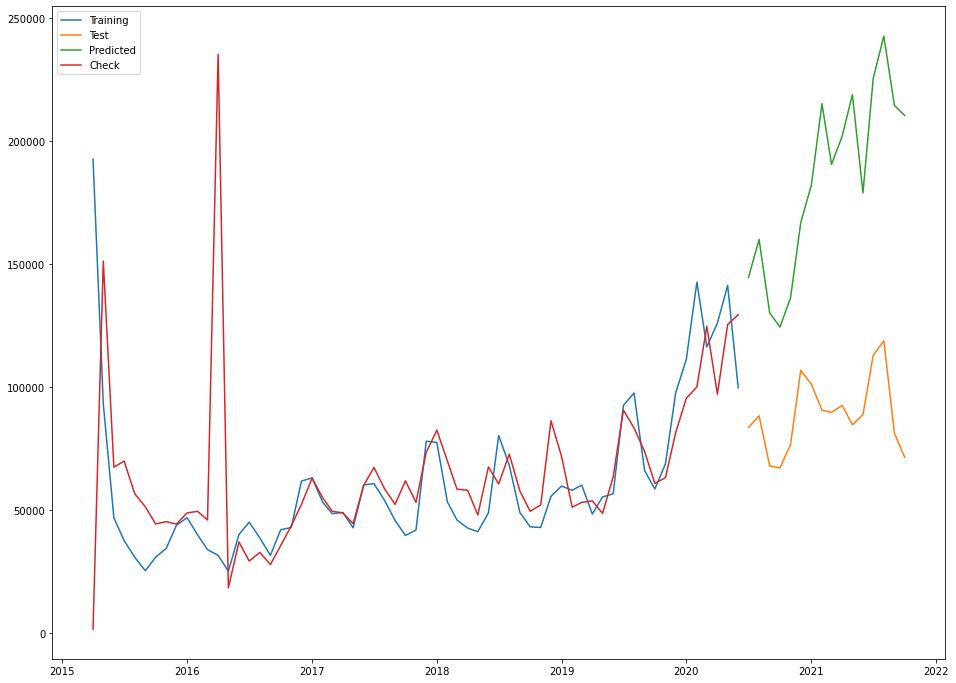

In [53]:
plt.figure(figsize = (16, 12))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.plot(check,label="Check")
plt.legend()
plt.show()